# Patient Survival Prediction Modeling<a id='Modeling'></a>

# Contents<a id='Contents'></a>
* [Patient Survival Prediction Modeling](#Modeling)
* [Contents](#Contents)
  * [1 Imports](#1_Imports)
  * [2 Load Data](#2_Load_Data)
  * [3 Explore the Data](#3_Explore_the_Data)
  * [4 Training Testing Split](#4)
  * [5 Missing values](#5)
    * [5.1 Fill the gender randomly](#5.1)
    * [5.2 Fill data with approximately normal distribution with mean.](#5.2)
    * [5.3 Fill other skewed numerical data with median](#5.3)
    * [5.4 Fill categorical data with mode](#5.4)
  * [6 Feature Engineering](#6)
    * [6.1 Label Encoding](#6.1)
    * [6.2 One hot Encoding](#6.2)
    * [6.3 Log Transformations](#6.3)
  * [7 Feature Selection](#7)  
  * [8 Modeling](#8)
    * [8.1 Logistic Regression](#8.1)
    * [8.2 Naive Bayes](#8.2)
    * [8.3 Random Forest](#8.3)
    * [8.4 XGBoost](#8.4)    
    * [8.5 BalancedRandomForestClassifier](#8.5)
    * [8.6 BalancedBaggingClassifier](#8.6)
  * [9 Model Metrics Comparison](#9)
    * [9.1 Accuracy & F1 Score](#9.1)
    * [9.2 Precision/Recall Curve](#9.2)
    * [9.3 ROC & AUC](#9.3)
  * [10 Hyperparametter Tuning](#10)
    * [10.1 Random Forest](#10.1)
    * [10.2 XGBoost](#10.2)
    * [10.3 BalancedRandomForestClassifier](#10.3)
  * [11 Evaluate & Save The Best Model](#11)
    * [11.1 Evaluate the Feature Importance](#11.1)
    * [11.2 Evaluate the Predictive power](#11.2)
      * [11.2.1 Use apache_4a_icu_death_prob to predict the patient death](#11.2.1)
      * [11.2.2 Use apache_4a_hospital_death_prob to predict the patient death](#11.2.2)
      * [11.2.3 The predictive power of our best model](#11.2.3)
    * [11.3 Save the Best Model](#11.3)

# 1. Imports<a id='1_Imports'></a>

In [1]:
import pandas as pd
import numpy as np
import random
import time
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve, cross_val_score, RepeatedStratifiedKFold
from sklearn import __version__ as sklearn_version
from sklearn.preprocessing import scale, StandardScaler, MinMaxScaler, Normalizer, Binarizer
from sklearn.metrics import f1_score, mean_squared_error, mean_absolute_error, confusion_matrix, roc_curve, roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif,chi2
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
import scipy.stats
from scipy.stats import uniform as sp_rand

pd.options.display.max_rows = 15
import warnings
warnings.filterwarnings('ignore')

# 2. Load Data<a id='2_Load_Data'></a>

In [2]:
patient = pd.read_csv('../data/Patient_data_cleaned.csv')
patient.head()

,age,bmi,elective_surgery,ethnicity,gender,height,icu_admit_source,icu_stay_type,icu_type,pre_icu_los_days,...,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,hospital_death,AgeGroup
0,68.0,22.73,0,Caucasian,M,180.3,Floor,admit,CTICU,0.541667,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,0,60-80
1,77.0,27.42,0,Caucasian,F,160.0,Floor,admit,Med-Surg ICU,0.927778,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,0,60-80
2,25.0,31.95,0,Caucasian,F,172.7,Accident & Emergency,admit,Med-Surg ICU,0.000694,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,0,20-40
3,81.0,22.64,1,Caucasian,F,165.1,Operating Room / Recovery,admit,CTICU,0.000694,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,0,80-100
4,67.0,27.56,0,Caucasian,M,190.5,Accident & Emergency,admit,Med-Surg ICU,0.000694,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Neurological,0,60-80


# 3. Explore the Data<a id='3_Explore_the_Data'></a>

In [46]:
patient.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84026 entries, 0 to 84025
Data columns (total 80 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            80783 non-null  float64
 1   bmi                            81118 non-null  float64
 2   elective_surgery               84026 non-null  int64  
 3   ethnicity                      82852 non-null  object 
 4   gender                         84013 non-null  object 
 5   height                         82989 non-null  float64
 6   icu_admit_source               83941 non-null  object 
 7   icu_stay_type                  84026 non-null  object 
 8   icu_type                       84026 non-null  object 
 9   pre_icu_los_days               84026 non-null  float64
 10  weight                         81699 non-null  float64
 11  apache_2_diagnosis             83262 non-null  float64
 12  apache_3j_diagnosis            83778 non-null 

Check the object and int type of data if they are ordinal data

In [47]:
patient.select_dtypes(['object','int']).nunique()

elective_surgery          2
ethnicity                 6
gender                    2
icu_admit_source          5
icu_stay_type             3
icu_type                  8
apache_post_operative     2
apache_3j_bodysystem     11
hospital_death            2
AgeGroup                  5
dtype: int64

In [3]:
col_list=patient.select_dtypes(['object','int']).columns

In [49]:
for col in col_list:
    value_counts=patient[col].value_counts()
    print(value_counts) 

elective_surgery
0    68424
1    15602
Name: count, dtype: int64
ethnicity
Caucasian           64792
African American     8647
Other/Unknown        4086
Hispanic             3552
Asian                1027
Native American       748
Name: count, dtype: int64
gender
M    45357
F    38656
Name: count, dtype: int64
icu_admit_source
Accident & Emergency         49878
Operating Room / Recovery    17289
Floor                        14024
Other Hospital                2203
Other ICU                      547
Name: count, dtype: int64
icu_stay_type
admit       79103
transfer     4479
readmit       444
Name: count, dtype: int64
icu_type
Med-Surg ICU    46058
MICU             7294
Neuro ICU        7061
CCU-CTICU        6449
SICU             4908
CSICU            4396
Cardiac ICU      4339
CTICU            3521
Name: count, dtype: int64
apache_post_operative
0    67003
1    17023
Name: count, dtype: int64
apache_3j_bodysystem
Cardiovascular          27348
Neurological            11048
Sepsis        

We can see that only the AgeGroup is the ordinal feature and we should apply label encoding on this column and apply one hot encoding on the rest categorical features.

# 4. Training Testing Split<a id='4'></a>

In [4]:
X=patient.drop('hospital_death', axis=1)
y=patient[['hospital_death']]

Let's do the train/test split.

In [5]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=12)

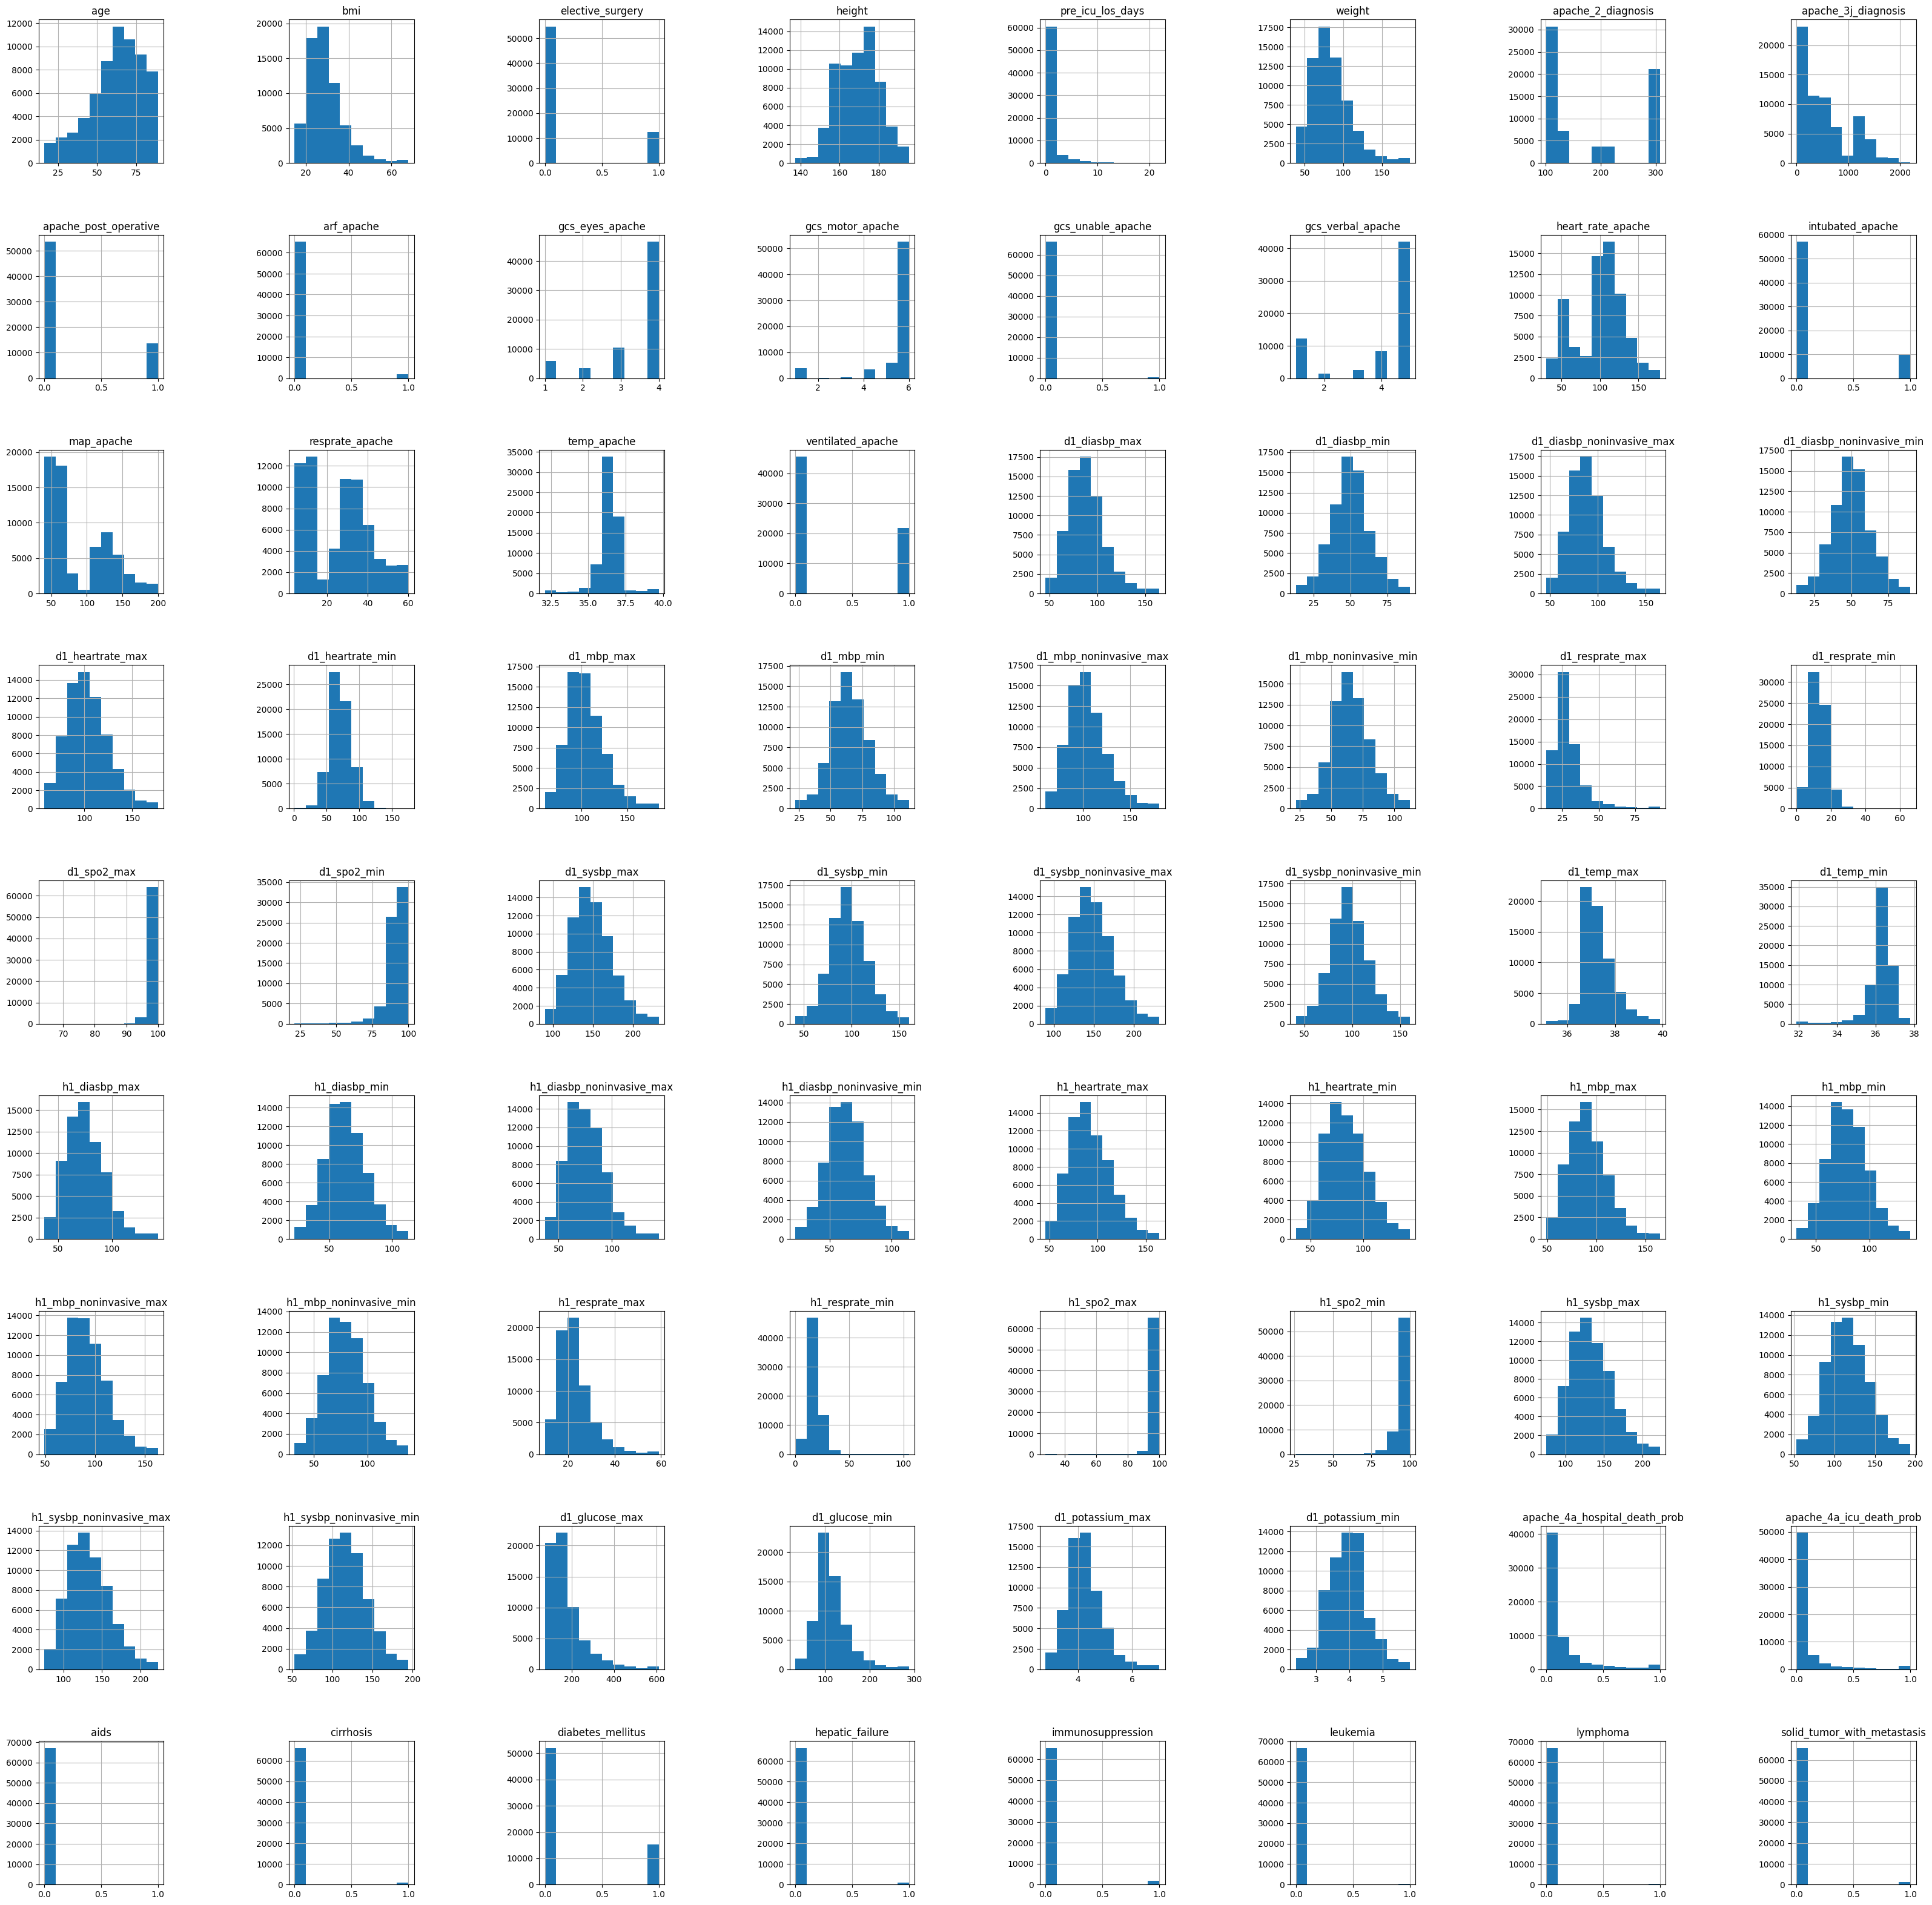

In [52]:
#Check the distrbution of features
X_train.hist(figsize=(40,40))
plt.subplots_adjust(wspace=1,hspace=0.5);

# 5. Missing values<a id='5'></a>
I fill the missing values based on following rules:
When the missing values are numerical and the distribution of the variable is approximately normal, I fill with mean.
When the distribution is skewed, I fill with median.
When the feature is categorical variables or numerical variables with a small number of unique values, I fill with mode.

## 5.1 Fill the gender randomly <a id='5.1'></a>

In [6]:
#fill gender
X_train['gender'].fillna(method='bfill')
X_test['gender'].fillna(method='bfill')

62903    F
15088    M
82298    F
75665    M
54757    F
        ..
38722    M
63796    M
21514    M
69095    F
82404    F
Name: gender, Length: 16806, dtype: object

## 5.2 Fill data with approximately normal distribution with mean.<a id='5.2'></a>

the weight and height distribution are approximately normal, so we use mean to fill the na, but it do affected by gender, so we use gender to group.

In [7]:
#fill weight based on the gender for the Training set
X_train.loc[X_train['gender']=='F',"weight"]\
=X_train.loc[X_train['gender']=='F',"weight"].\
fillna(value=X_train.loc[X_train['gender']=='F',"weight"].mean())
#fill weight based on the gender for the Testing set
X_test.loc[X_test['gender']=='F',"weight"]\
=X_test.loc[X_test['gender']=='F',"weight"].\
fillna(value=X_train.loc[X_train['gender']=='F',"weight"].mean())

#fill weight based on the gender for the Training set
X_train.loc[X_train['gender']=='M',"weight"]\
=X_train.loc[X_train['gender']=='M',"weight"].\
fillna(value=X_train.loc[X_train['gender']=='M',"weight"].mean())
#fill weight based on the gender for the Testing set
X_test.loc[X_test['gender']=='M',"weight"]\
=X_test.loc[X_test['gender']=='M',"weight"].\
fillna(value=X_train.loc[X_train['gender']=='M',"weight"].mean())

In [8]:
#fill Height based on the gender for the Training set
X_train.loc[X_train['gender']=='F',"height"]\
=X_train.loc[X_train['gender']=='F',"height"].\
fillna(value=X_train.loc[X_train['gender']=='F',"height"].mean())
#fill Height based on the gender for the Testing set
X_test.loc[X_test['gender']=='F',"height"]\
=X_test.loc[X_test['gender']=='F',"height"].\
fillna(value=X_train.loc[X_train['gender']=='F',"height"].mean())

#fill Height based on the gender for the Training set
X_train.loc[X_train['gender']=='M',"height"]\
=X_train.loc[X_train['gender']=='M',"height"].\
fillna(value=X_train.loc[X_train['gender']=='M',"height"].mean())
#fill Height based on the gender for the Testing set
X_test.loc[X_test['gender']=='M',"height"]\
=X_test.loc[X_test['gender']=='M',"height"].\
fillna(value=X_train.loc[X_train['gender']=='M',"height"].mean())

In [9]:
#calculate bmi
X_train['bmi']= X_train['weight']/(X_train['height']/100)**2
X_test['bmi']= X_test['weight']/(X_test['height']/100)**2

In [10]:
numerical=X_train.loc[:,X_train.nunique()>11]
#fillter those features based on skewness.
skewness_data =numerical.agg(['skew', 'kurtosis']).transpose()
feature_skew = skewness_data[(skewness_data['skew'] > 1)|(skewness_data['skew'] <-1)].index.tolist()
feature_norm = skewness_data[(skewness_data['skew'] < 1)|(skewness_data['skew'] >-1)].index.tolist()

In [11]:
#fill other roughly numerical data with mean
X_train[feature_norm]=X_train[feature_norm].fillna(X_train[feature_norm].mean())
X_test[feature_norm]=X_test[feature_norm].fillna(X_train[feature_norm].mean())

## 5.3 Fill other skewed numerical data with median<a id='5.3'></a>

In [12]:
X_train[feature_skew]=X_train[feature_skew].fillna(X_train[feature_skew].median())
X_test[feature_skew]=X_test[feature_skew].fillna(X_train[feature_skew].median())

## 5.4 Fill categorical data with mode<a id='5.4'></a>

In [13]:
cate=X_train.loc[:,X_train.nunique()<12]
col_to_fill=cate.columns.tolist()
for col in col_to_fill:
    mode = X_train[col].mode()[0]
    X_train[col].fillna(mode, inplace=True)

In [14]:
for col in col_to_fill:
    mode = X_train[col].mode()[0]
    X_test[col].fillna(mode, inplace=True)

Check if there still have NAs

In [15]:
X_train.isnull().sum()

age                            0
bmi                            0
elective_surgery               0
ethnicity                      0
gender                         0
                              ..
leukemia                       0
lymphoma                       0
solid_tumor_with_metastasis    0
apache_3j_bodysystem           0
AgeGroup                       0
Length: 79, dtype: int64

# 6. Feature Engineering<a id='6'></a>

## 6.1 Label Encoding<a id='6.1'></a>
For the AgeGroup column, we use label encoding to transform the original categorical feature into a group of number.

In [16]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
# Apply label encoding to AgeGroup column in the list
X_train['Age_group_encoded'] = label_encoder.fit_transform(X_train['AgeGroup'])
X_train=X_train.drop('AgeGroup',axis=1)
X_test['Age_group_encoded'] = label_encoder.fit_transform(X_test['AgeGroup'])
X_test=X_test.drop('AgeGroup',axis=1)

## 6.2 One hot Encoding<a id='6.2'></a>
We use one-hot encoding to transform the rest of the categorical features.

In [17]:
#columns need to be encoded
col_list=col_list.tolist()
col_list.remove('AgeGroup')
col_list.remove('hospital_death')

In [18]:
X_train=pd.get_dummies(X_train, columns=col_list, prefix=col_list, drop_first=True, dtype=int)
X_test=pd.get_dummies(X_test, columns=col_list, prefix=col_list, drop_first=True, dtype=int)

## 6.3 Log Transformations<a id='6.3'></a>

Some of the features are super skew. So we might need to do log transformations to these features.
Lets check the skewness of the features.

In [19]:
non_binary_features_names = X_train.columns[X_train.nunique() > 2].tolist()
non_binary_features=X_train[non_binary_features_names]

Log transformation for the features that have positive skewness 

In [20]:
skewness_data =non_binary_features.agg(['skew', 'kurtosis']).transpose()
#fillter those features that have a skewness larger than 1.
log_features = skewness_data[(skewness_data['skew'] > 1)]
selected_feature_names = log_features.index.tolist()
selected_features = X_train[selected_feature_names]
# Apply the log transformation to the selected features
X_train[selected_feature_names] = X_train[selected_feature_names].apply(lambda x: np.log1p(x))
X_test[selected_feature_names] = X_test[selected_feature_names].apply(lambda x: np.log1p(x))

Log transformation for the features that have negtive skewness 

In [21]:
log_features_neg = skewness_data[(skewness_data['skew'] < -1)]
selected_feature_names_neg = log_features_neg.index.tolist()
selected_features_neg = X_train[selected_feature_names_neg]
# Apply the log transformation to the selected features
X_train[selected_feature_names_neg] = X_train[selected_feature_names_neg].apply(lambda x: np.log1p(x))
X_test[selected_feature_names] = X_test[selected_feature_names].apply(lambda x: np.log1p(x))

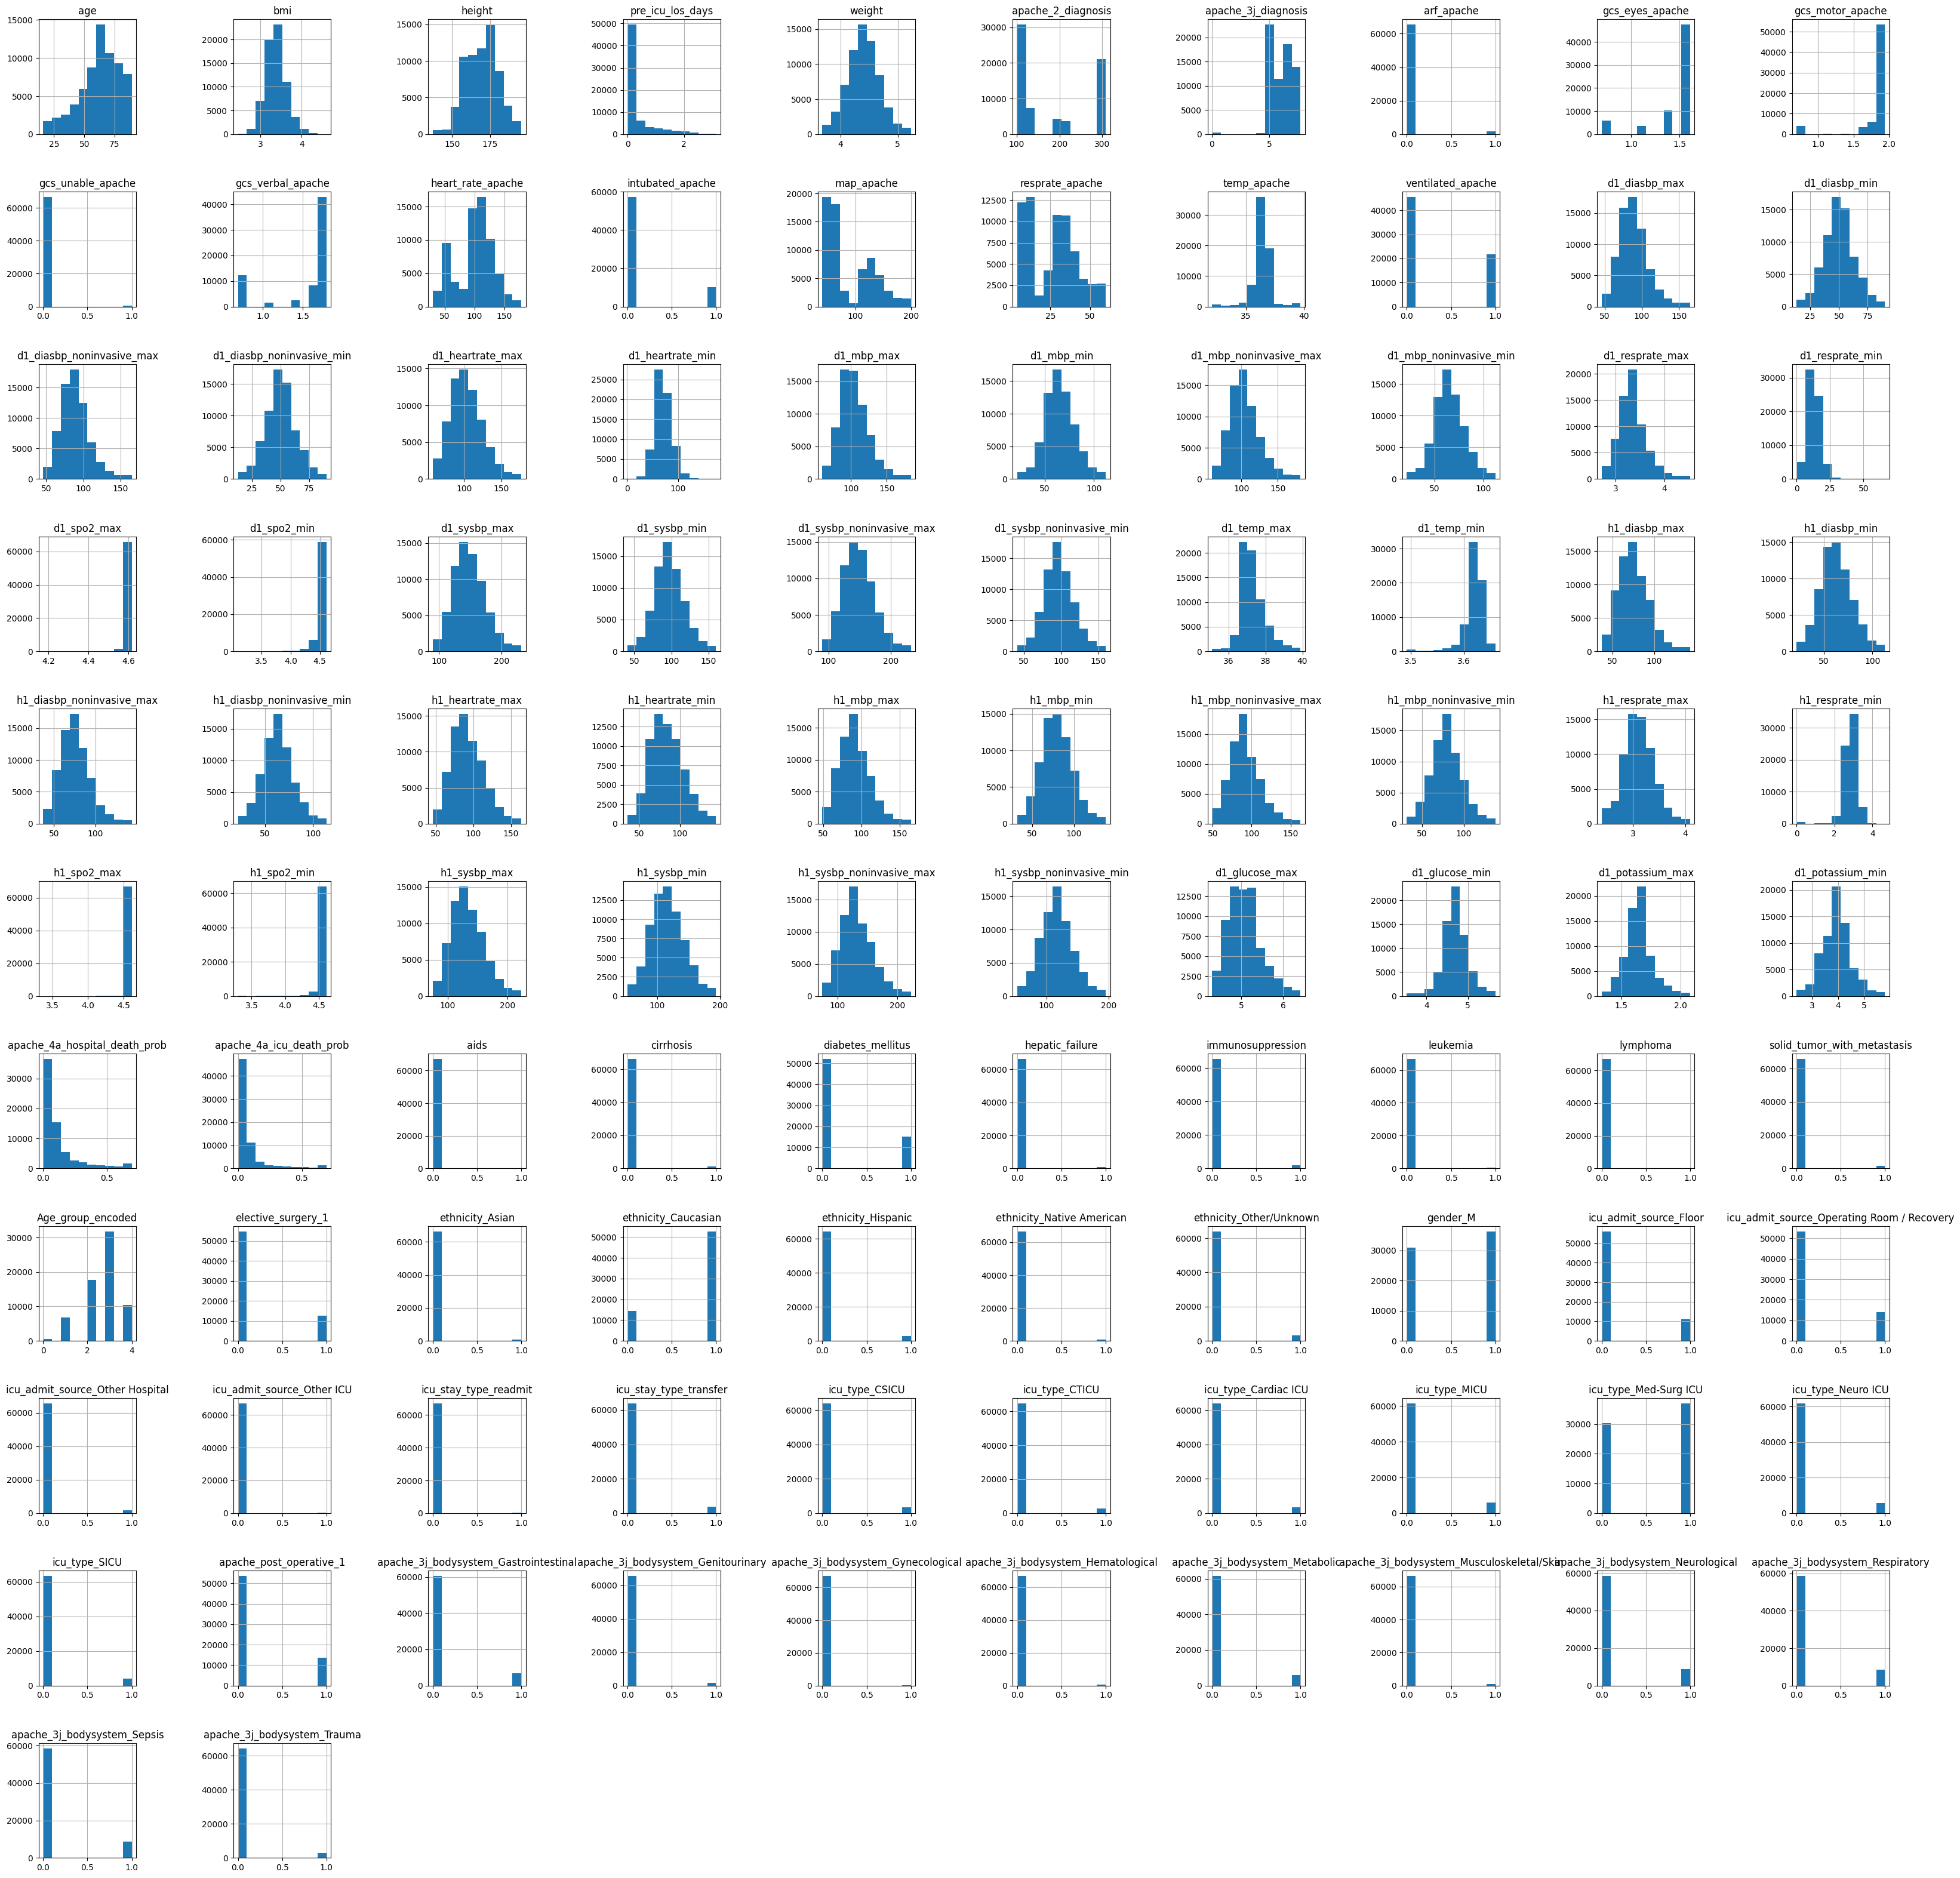

In [69]:
#Check the distrbution of features again
X_train.hist(figsize=(40,40))
plt.subplots_adjust(wspace=1,hspace=0.5);

some of the features looks better now.

# 7. Feature Selection<a id='7'></a>

In [23]:
from sklearn.ensemble import RandomForestClassifier
steps = [('under', RandomUnderSampler(random_state=12)), 
         ('model', RandomForestClassifier(random_state=12))]
pipeline = Pipeline(steps=steps)
score=[]
for i in range(102,0,-2):
    x_fschi = SelectKBest(f_classif,k = i).fit_transform(X_train, y_train)
    once = cross_val_score(pipeline,x_fschi,y_train,cv=5, scoring='f1').mean()
    score.append(once)

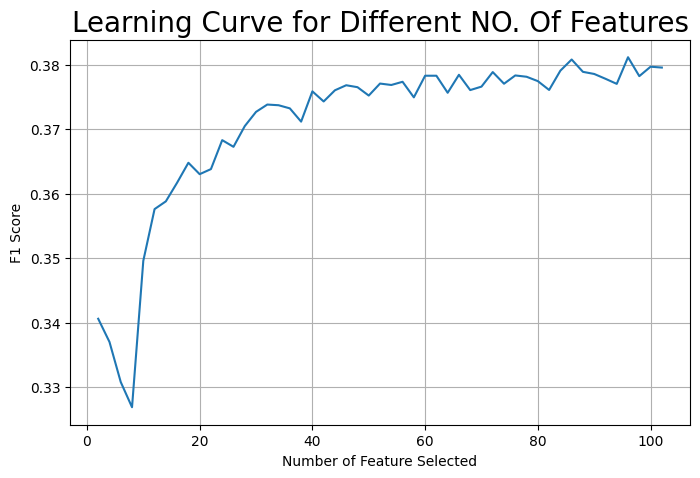

In [42]:
#Plot the learning curve
_ = plt.figure(figsize=(8,5))
_ = plt.grid()
_ = plt.plot(range(102,0,-2),score)
_ = plt.title('Learning Curve for Different NO. Of Features', size=20)
_ = plt.xlabel('Number of Feature Selected')
_ = plt.ylabel('F1 Score')
_ = plt.show()

There is a sharp rise for the f1 score at the beginning as the feature number increase, but when the feature number reaches around 40, the improve the f1 score began to slow down. For this prediction I will choose 60 features to use in the models.

In [22]:
kbest = SelectKBest(chi2,k = 60)
X_ktrain=kbest.fit_transform(X_train, y_train)
X_ktest=kbest.transform(X_test)
select_name_index = kbest.get_support(indices=True)
select_name = []
for i in select_name_index:
    select_name.append(X_train.columns[i])
len(select_name)

60

# 8. Modeling<a id='8'></a>

## 8.1 Logistic Regression<a id='8.1'></a>

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import RFECV

From the EAD we did, we know that this dataset is supper unbanlanced, the target variable have large amount of 0. To make sure our model works well, we need to resample the data before the tarining testing split.

In [24]:
#pipeline with Standardlize scaler
steps = [('scaler', StandardScaler()),
         ('under', RandomUnderSampler(random_state=12)), 
         ('model', LogisticRegression(random_state=12))]
pipeline = Pipeline(steps=steps)
lg_model=pipeline.fit(X_ktrain, y_train.hospital_death)

In [25]:
# evaluate pipeline
y_pred = lg_model.predict(X_ktest)
y_trainpred = lg_model.predict(X_ktrain)
accuracy_test = accuracy_score(y_test, y_pred)
accuracy_train=accuracy_score(y_train, y_trainpred)
report = classification_report(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)

print("Train Accuracy:",accuracy_train)
print("Test Accuracy:", accuracy_test)
print("Classification Report:\n", report)
print(confusion)

Train Accuracy: 0.7903302588515323
Test Accuracy: 0.914613828394621
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.97      0.95     15428
           1       0.47      0.30      0.37      1378

    accuracy                           0.91     16806
   macro avg       0.70      0.64      0.66     16806
weighted avg       0.90      0.91      0.91     16806

[[14951   477]
 [  958   420]]


## 8.2 Bernoulli Naive Bayes<a id='8.2'></a>

In [26]:
from sklearn.naive_bayes import BernoulliNB
steps=[('scaler',StandardScaler()), 
       ('under', RandomUnderSampler(random_state=12)), 
       ('model', BernoulliNB())] 
pipeline=Pipeline(steps=steps)
nb_model=pipeline.fit(X_ktrain, y_train.hospital_death)

In [27]:
y_pred = nb_model.predict(X_ktest)
y_trainpred = nb_model.predict(X_ktrain)
accuracy_test = accuracy_score(y_test, y_pred)
accuracy_train=accuracy_score(y_train, y_trainpred)
report = classification_report(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)

print("Train Accuracy:",accuracy_train)
print("Test Accuracy:", accuracy_test)
print("Classification Report:\n", report)
print(confusion)

Train Accuracy: 0.7319994049390063
Test Accuracy: 0.7478281566107342
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.75      0.85     15428
           1       0.21      0.72      0.32      1378

    accuracy                           0.75     16806
   macro avg       0.59      0.74      0.58     16806
weighted avg       0.91      0.75      0.80     16806

[[11573  3855]
 [  383   995]]


## 8.3 Random Forest<a id='8.3'></a>

In [29]:
# define pipeline
from sklearn.ensemble import RandomForestClassifier

steps = [('under', RandomUnderSampler(random_state=12)), 
         ('model', RandomForestClassifier(random_state=12))]
pipeline = Pipeline(steps=steps)
rf_model=pipeline.fit(X_ktrain, y_train.hospital_death)

In [30]:
y_pred = rf_model.predict(X_ktest)
y_trainpred = rf_model.predict(X_ktrain)
accuracy_test = accuracy_score(y_test, y_pred)
accuracy_train=accuracy_score(y_train, y_trainpred)
report = classification_report(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)

print("Train Accuracy:",accuracy_train)
print("Test Accuracy:", accuracy_test)
print("Classification Report:\n", report)
print(confusion)

Train Accuracy: 0.8213180601011604
Test Accuracy: 0.7867428299416875
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.79      0.87     15428
           1       0.25      0.78      0.37      1378

    accuracy                           0.79     16806
   macro avg       0.61      0.78      0.62     16806
weighted avg       0.92      0.79      0.83     16806

[[12150  3278]
 [  306  1072]]


## 8.4 XGBoost<a id='8.4'></a>

In [31]:
import xgboost as xgb
steps=[('scaler',StandardScaler()), 
       ('under', RandomUnderSampler(random_state=12)), 
       ('model', xgb.XGBClassifier(objective='binary:logistic'))] 
pipeline=Pipeline(steps=steps)
xgb_model=pipeline.fit(X_ktrain, y_train.hospital_death)

In [32]:
y_pred = xgb_model.predict(X_ktest)
y_trainpred = xgb_model.predict(X_ktrain)
accuracy_test = accuracy_score(y_test, y_pred)
accuracy_train=accuracy_score(y_train, y_trainpred)
report = classification_report(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)

print("Train Accuracy:",accuracy_train)
print("Test Accuracy:", accuracy_test)
print("Classification Report:\n", report)
print(confusion)

Train Accuracy: 0.8110532579589408
Test Accuracy: 0.8120909199095561
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.82      0.89     15428
           1       0.26      0.71      0.38      1378

    accuracy                           0.81     16806
   macro avg       0.62      0.77      0.64     16806
weighted avg       0.91      0.81      0.85     16806

[[12671  2757]
 [  401   977]]


## 8.5 BalancedRandomForestClassifier<a id='8.5'></a>

In [33]:
from imblearn.ensemble import BalancedRandomForestClassifier

brf = BalancedRandomForestClassifier(sampling_strategy="all", replacement=True, random_state=12)
brf_model=brf.fit(X_ktrain, y_train.hospital_death)

In [34]:
y_pred = brf_model.predict(X_ktest)
y_trainpred = brf_model.predict(X_ktrain)
accuracy_test = accuracy_score(y_test, y_pred)
accuracy_train=accuracy_score(y_train, y_trainpred)
report = classification_report(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)

print("Train Accuracy:",accuracy_train)
print("Test Accuracy:", accuracy_test)
print("Classification Report:\n", report)
print(confusion)

Train Accuracy: 0.8694287414459982
Test Accuracy: 0.8341068665952636
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.85      0.90     15428
           1       0.29      0.71      0.41      1378

    accuracy                           0.83     16806
   macro avg       0.63      0.78      0.66     16806
weighted avg       0.91      0.83      0.86     16806

[[13037  2391]
 [  397   981]]


## 8.6 BalancedBaggingClassifier<a id='8.6'></a>

In [35]:
from imblearn.ensemble import BalancedBaggingClassifier
bbc=BalancedBaggingClassifier(random_state=12)
bbc_model=bbc.fit(X_ktrain, y_train.hospital_death)

In [36]:
y_pred = bbc_model.predict(X_ktest)
y_trainpred = bbc_model.predict(X_ktrain)
accuracy_test = accuracy_score(y_test, y_pred)
accuracy_train=accuracy_score(y_train, y_trainpred)
report = classification_report(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)

print("Train Accuracy:",accuracy_train)
print("Test Accuracy:", accuracy_test)
print("Classification Report:\n", report)
print(confusion)

Train Accuracy: 0.8939898839631062
Test Accuracy: 0.8408306557181959
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.86      0.91     15428
           1       0.28      0.59      0.38      1378

    accuracy                           0.84     16806
   macro avg       0.62      0.73      0.64     16806
weighted avg       0.90      0.84      0.87     16806

[[13321  2107]
 [  568   810]]


# 9. Model Metrics Comparison<a id='9'></a>

## 9.1 Accuracy & F1 Score<a id='9.1'></a>

In [166]:
Models=['Log Reg',
        'Bernoulli NB',
        'Rand Forest',
        'XGBoost',
        'Balanced RF',
        'Balanced Bagging']
Train_acc=[0.7903,0.732,0.8213,0.8111,0.8694,0.894]
Test_acc=[0.9146, 0.7478, 0.7867,0.8121, 0.8341,0.8408]
F1=[0.37,0.32,0.37,0.38,0.41,0.38]

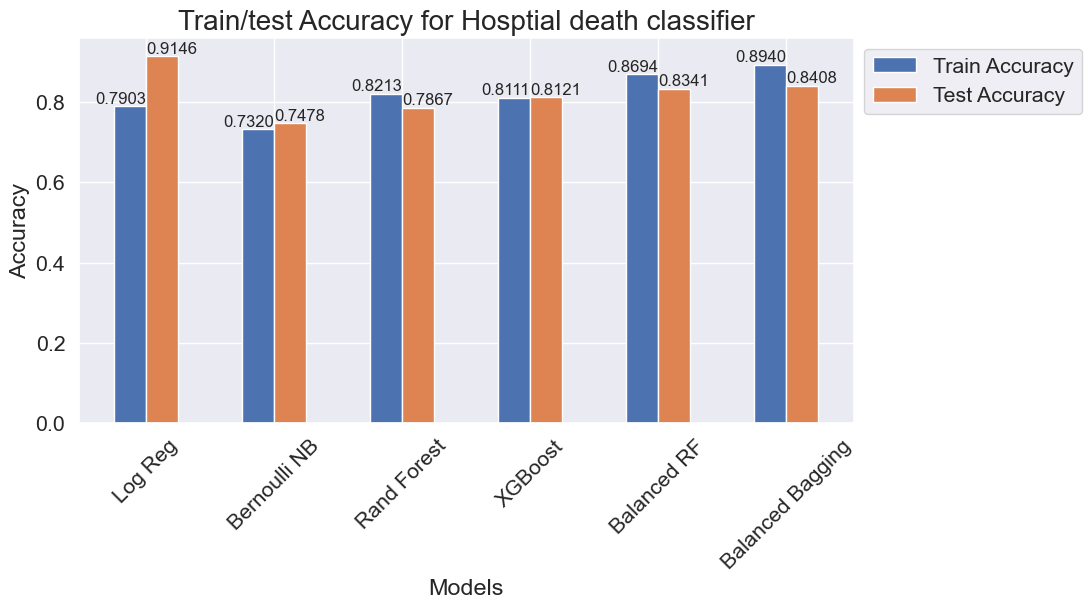

In [167]:
_ = plt.figure(figsize=(10,5))
_ = plt.title('Train/test Accuracy for Hosptial death classifier', size=20)
x = np.arange(len(Models))
width = 0.25 
_ =plt.bar(x - width/2, Train_acc, width, label='Train Accuracy')
_ =plt.bar(x + width/2, Test_acc, width, label='Test Accuracy')
_ =plt.xticks(x, labels=Models,rotation=45)
for i, acc in enumerate(Train_acc):
    plt.text(i, acc, f'{acc:.4f}', ha='right', va='bottom')
for i, acc in enumerate(Test_acc):
    plt.text(i, acc, f'{acc:.4f}', ha='left', va='bottom')
_ =plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
_ = plt.xlabel('Models')
_ = plt.ylabel('Accuracy')
_ = plt.show()

The logistic Regression model has the highest test accuracy, but its test accuracy is much higher than its train accuracy, so this model has a underfitting problem. Overall, the Balanced Bagging model perform best in terms of accuracy. Random Forest, XGBoost and Balanced Random Forest all have a relatively decent accuracy.

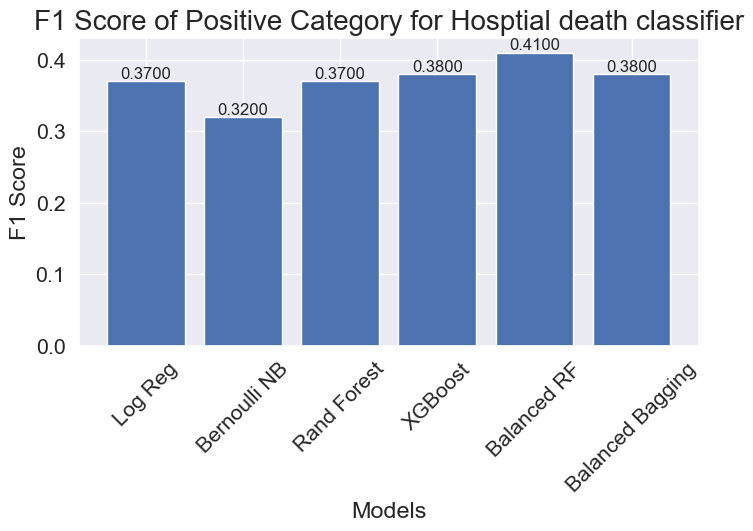

In [146]:
_ = plt.figure(figsize=(8,4))
_ = plt.title('F1 Score of Positive Category for Hosptial death classifier', size=20)
_ =plt.bar(Models, F1)
_ =plt.xticks(x, labels=Models,rotation=45)
for i, f in enumerate(F1):
    plt.text(i, f, f'{f:.4f}', ha='center', va='bottom')
_ = plt.xlabel('Models')
_ = plt.ylabel('F1 Score')
_ = plt.show()

The f1 score for all these 6 models are not very high. Because all these models perform poor on predicting the positive value. Balanced Random Forest has the highest f1 score in these models.

## 9.2 Precision/Recall Curve<a id='9.2'></a>

In [112]:
from sklearn.metrics import auc, precision_recall_curve
#caculate the precision and recall for all the models
#Logistic regression model
y_pred_prob_lg = lg_model.predict_proba(X_ktest)[:, 1]
prc_lg, rec_lg, thresholds_lg = precision_recall_curve(y_test, y_pred_prob_lg)
#Bernoulli Naive Bayes model
y_pred_prob_nb = nb_model.predict_proba(X_ktest)[:, 1]
prc_nb, rec_nb, thresholds_nb = precision_recall_curve(y_test, y_pred_prob_nb)
#Random forest model
y_pred_prob_rf = rf_model.predict_proba(X_ktest)[:, 1]
prc_rf, rec_rf, thresholds_rf = precision_recall_curve(y_test, y_pred_prob_rf)
#XGBoost
y_pred_prob_xgb = xgb_model.predict_proba(X_ktest)[:, 1]
prc_xgb, rec_xgb, thresholds_xgb = precision_recall_curve(y_test, y_pred_prob_xgb)
#BalancedRandomForestClassifier
y_pred_prob_brf = brf_model.predict_proba(X_ktest)[:, 1]
prc_brf, rec_brf, thresholds_brf = precision_recall_curve(y_test, y_pred_prob_brf)
#BalancedBaggingClassifier
y_pred_prob_bbc = bbc_model.predict_proba(X_ktest)[:, 1]
prc_bbc, rec_bbc, thresholds_bbc = precision_recall_curve(y_test, y_pred_prob_bbc)


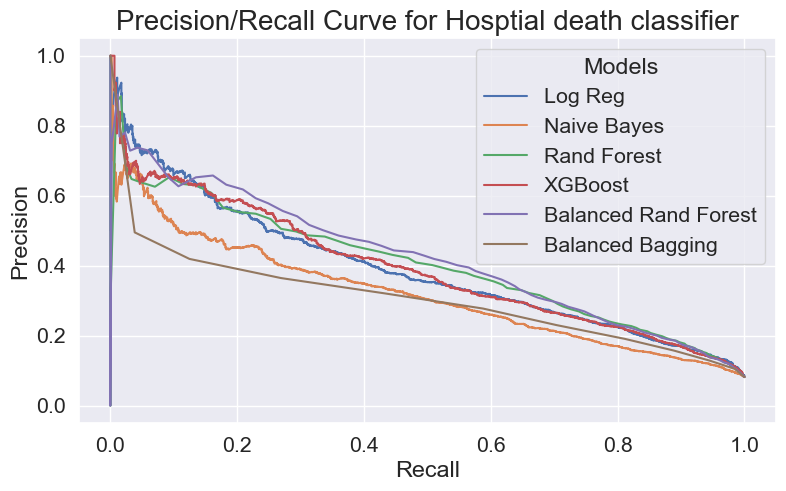

In [155]:
#plot the Precision/Recall Curve for each model
_ = plt.figure(figsize=(9,5))
_ = plt.title('Precision/Recall Curve for Hosptial death classifier', size=20)
_ = plt.plot(rec_lg, prc_lg, label = 'Log Reg')
_ = plt.plot(rec_nb, prc_nb, label = 'Naive Bayes')
_ = plt.plot(rec_rf, prc_rf, label = 'Rand Forest')
_ = plt.plot(rec_xgb, prc_xgb, label = 'XGBoost')
_ = plt.plot(rec_brf, prc_brf, label = 'Balanced Rand Forest')
_ = plt.plot(rec_bbc, prc_bbc, label = 'Balanced Bagging')

_ = plt.xlabel('Recall')
_ = plt.ylabel('Precision')
_ = plt.legend(title='Models')
_ = plt.show()

Besides accuracy and f1 scores I also want to investigate the tradeoff between precision and recall for all these models. From the graph we can easily infer that although Balanced Bagging have a relatively higher accuracy, its precision drops fast as its recall increases, so does the Naïve Bayes metrics. Logistic Regression and Balanced Random Forest perform better in terms of the Precision-Recall Curve.

## 9.3 ROC & AUC<a id='9.3'></a>

In [108]:
#caculate the fpr and tpr and auc for all the models
#Logistic regression model
fpr_lg, tpr_lg, thresholds_lg = roc_curve(y_test, y_pred_prob_lg)
auc_lg=roc_auc_score(y_test, y_pred_prob_lg)

#Bernoulli Naive Bayes model
fpr_nb, tpr_nb, thresholds_nb = roc_curve(y_test, y_pred_prob_nb)
auc_nb=roc_auc_score(y_test, y_pred_prob_nb)

#Random forest model
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_prob_rf)
auc_rf=roc_auc_score(y_test, y_pred_prob_rf)

#XGBoost
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, y_pred_prob_xgb)
auc_xgb=roc_auc_score(y_test, y_pred_prob_xgb)

#BalancedRandomForestClassifier
fpr_brf, tpr_brf, thresholds_brf = roc_curve(y_test, y_pred_prob_brf)
auc_brf=roc_auc_score(y_test, y_pred_prob_brf)

#BalancedBaggingClassifier
fpr_bbc, tpr_bbc, thresholds_bbc = roc_curve(y_test, y_pred_prob_bbc)
auc_bbc=roc_auc_score(y_test, y_pred_prob_bbc)

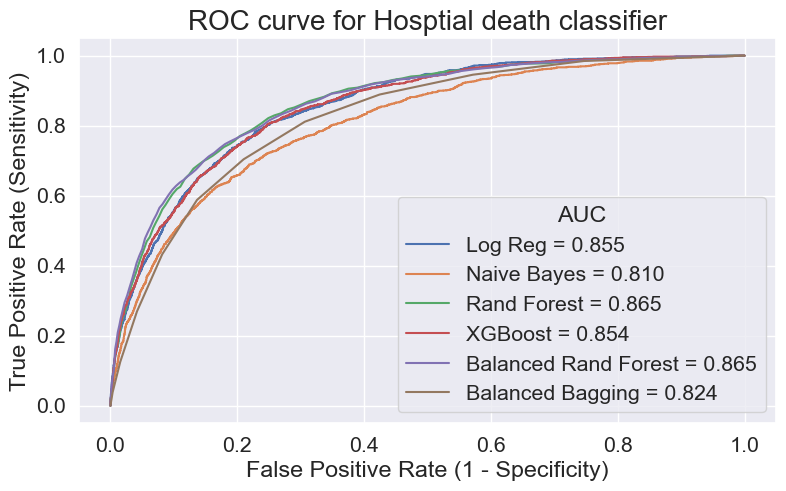

In [156]:
#Plot the roc curve for each model
_ = plt.figure(figsize=(9,5))
_ = plt.title('ROC curve for Hosptial death classifier', size=20)
_ = plt.plot(fpr_lg, tpr_lg, label = 'Log Reg = %0.3f' % auc_lg)
_ = plt.plot(fpr_nb, tpr_nb, label = 'Naive Bayes = %0.3f' % auc_nb)
_ = plt.plot(fpr_rf, tpr_rf, label = 'Rand Forest = %0.3f' % auc_rf)
_ = plt.plot(fpr_xgb, tpr_xgb, label = 'XGBoost = %0.3f' % auc_xgb)
_ = plt.plot(fpr_brf, tpr_brf, label = 'Balanced Rand Forest = %0.3f' % auc_brf)
_ = plt.plot(fpr_bbc, tpr_bbc, label = 'Balanced Bagging = %0.3f' % auc_bbc)

_ = plt.ylabel('True Positive Rate (Sensitivity)')
_ = plt.xlabel('False Positive Rate (1 - Specificity)')
_ = plt.legend(title='AUC')
_ = plt.show()

Balanced Random Forest and Random Forest yield a better AUC.

After considering the accuracy, confusion matrices, f1 score, precision-recall tradeoff, and AUC score for all these models, I will choose Random Forest, XGBoost and Balanced Random Forest to apply the hyperparameter tuning process.

# 10. Hyperparametter Tuning<a id='10'></a>

For this problem, we are trying to target more patient failure as well as reduce the false prediction, so precision and recall are both important to this problem, I will choose f1 score as the scoring method for the hyperparameter tuning

## 10.1 RandomForest <a id='10.1'></a>

In [45]:
steps = [('under', RandomUnderSampler(random_state=12)), 
         ('model', RandomForestClassifier(random_state=12))]
pipeline = Pipeline(steps=steps)
param_dist = {
        'under__sampling_strategy':sp_rand(0,1),
        'model__n_estimators': range(5,150,1),
        'model__criterion':['gini', 'entropy'],
        'model__max_features': ['sqrt', 'log2',None],
        'model__max_depth': [10,90],
        'model__min_samples_split': range(2,10,1),
        'model__min_samples_leaf': range(1,7,1)
    }
start=time.time()
rf_random_search = RandomizedSearchCV(pipeline, param_distributions=param_dist, n_iter=50, cv=5, scoring='f1',random_state=12)
rf_random_search.fit(X_ktrain, y_train.hospital_death)
end=time.time()
cost=end-start
print('Time consuming(Seconds):',cost)

Time consuming(Seconds): 2316.2731399536133


In [46]:
best_model = rf_random_search.best_estimator_
best_params = rf_random_search.best_params_
best_score = rf_random_search.best_score_
y_pred = best_model.predict(X_ktest)
y_trainpred = best_model.predict(X_ktrain)
accuracy_test = accuracy_score(y_test, y_pred)
accuracy_train= accuracy_score(y_train, y_trainpred)
report = classification_report(y_test, y_pred)

print("Best Parameters:", best_params)
print("Best Model's Mean Cross-Validation Score:", best_score)
print("Train Accuracy:",accuracy_train)
print("Test Accuracy:", accuracy_test)
print("Classification Report:\n", report)


Best Parameters: {'model__criterion': 'gini', 'model__max_depth': 90, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 5, 'model__min_samples_split': 3, 'model__n_estimators': 84, 'under__sampling_strategy': 0.32258573270881385}
Best Model's Mean Cross-Validation Score: 0.4622944590636133
Train Accuracy: 0.9333680452246356
Test Accuracy: 0.9021182910865168
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.94      0.95     15428
           1       0.42      0.50      0.46      1378

    accuracy                           0.90     16806
   macro avg       0.69      0.72      0.70     16806
weighted avg       0.91      0.90      0.91     16806



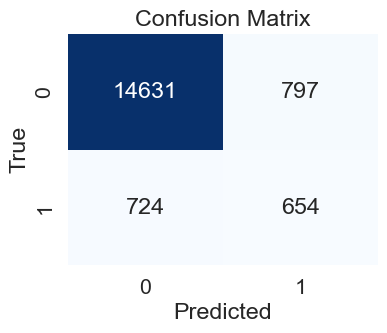

In [180]:
confusion = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 3))
sns.set(font_scale=1.4)  # Adjust the font scale for readability
# Use seaborn's heatmap to plot the confusion matrix
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=[0, 1], yticklabels=[0, 1])
# Set axis labels
plt.xlabel('Predicted')
plt.ylabel('True')
# Add a title
plt.title('Confusion Matrix')
# Show the plot
plt.show()

0.8682881726361849


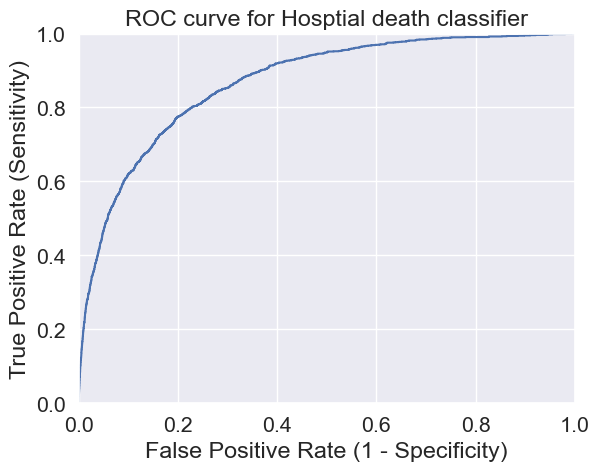

In [179]:
y_pred_prob = best_model.predict_proba(X_ktest)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for Hosptial death classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)
print(roc_auc_score(y_test, y_pred_prob))

## 10.2 XGBoost<a id='10.2'></a>

In [39]:
steps=[('scaler',StandardScaler()), 
       ('under', RandomUnderSampler(random_state=12)), 
       ('model', xgb.XGBClassifier(objective='binary:logistic'))] 
pipeline=Pipeline(steps=steps)
param_dist = {
        'under__sampling_strategy':sp_rand(0,1),
        'model__eta': sp_rand(0,1),
        'model__gamma':sp_rand(0,10),
        'model__min_child_weight': range(1,10,1),
        'model__max_depth': [10,30,50,90],
        'model__colsample_bytree': sp_rand(0,1),
        'model__subsample': sp_rand(0,1),
        'model__lambda': sp_rand(0,10)
    }
start=time.time()
xgb_random_search = RandomizedSearchCV(pipeline, param_distributions=param_dist, n_iter=50, cv=5, scoring='f1',random_state=12)
xgb_random_search.fit(X_ktrain, y_train.hospital_death)
end=time.time()
cost=end-start
print('Time consuming(Seconds):',cost)

Time consuming(Seconds): 325.22690892219543


In [169]:
best_model = xgb_random_search.best_estimator_
best_params = xgb_random_search.best_params_
best_score = xgb_random_search.best_score_
y_pred = best_model.predict(X_ktest)
y_trainpred = best_model.predict(X_ktrain)
accuracy_test = accuracy_score(y_test, y_pred)
accuracy_train= accuracy_score(y_train, y_trainpred)
report = classification_report(y_test, y_pred)

print("Best Parameters:", best_params)
print("Best Model's Mean Cross-Validation Score:", best_score)
print("Train Accuracy:",accuracy_train)
print("Test Accuracy:", accuracy_test)
print("Classification Report:\n", report)


Best Parameters: {'model__colsample_bytree': 0.85874211666461, 'model__eta': 0.45994220608720116, 'model__gamma': 3.157341551082362, 'model__lambda': 7.845133362824423, 'model__max_depth': 1, 'model__min_child_weight': 1, 'model__subsample': 0.4789612649136499, 'under__sampling_strategy': 0.26478509360624347}
Best Model's Mean Cross-Validation Score: 0.4593967893834118
Train Accuracy: 0.908628384409402
Test Accuracy: 0.8955135070808045
Train MAE: 0.09137161559059803
Test MAE: 0.10448649291919553
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.93      0.94     15428
           1       0.40      0.54      0.46      1378

    accuracy                           0.90     16806
   macro avg       0.68      0.73      0.70     16806
weighted avg       0.91      0.90      0.90     16806



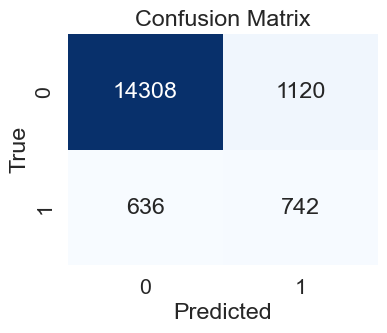

In [170]:
confusion = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 3))
sns.set(font_scale=1.4)  # Adjust the font scale for readability
# Use seaborn's heatmap to plot the confusion matrix
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=[0, 1], yticklabels=[0, 1])
# Set axis labels
plt.xlabel('Predicted')
plt.ylabel('True')
# Add a title
plt.title('Confusion Matrix')
# Show the plot
plt.show()

AUC : 0.8676065335376878


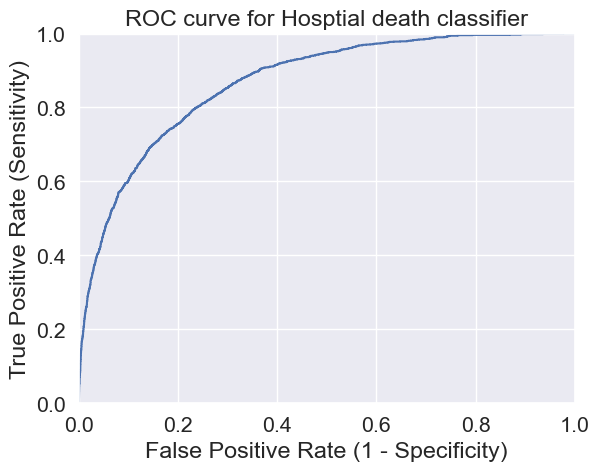

In [173]:
y_pred_prob = best_model.predict_proba(X_ktest)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for Hosptial death classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)
print('AUC :',roc_auc_score(y_test, y_pred_prob))

## 10.3 BalancedRandomForestClassifier<a id='10.3'></a>

In [239]:
brf = BalancedRandomForestClassifier(sampling_strategy="all", replacement=True, random_state=12)
param_dist = {
        'n_estimators': range(5,150,1),
        'criterion':['gini', 'entropy'],
        'max_features': ['sqrt', 'log2',None],
        'max_depth': [10,30,50,90],
        'min_samples_split': range(2,10,1),
        'min_samples_leaf': range(1,7,1)
    }
start=time.time()
brf_random_search = RandomizedSearchCV(brf, param_distributions=param_dist, n_iter=50, cv=5, scoring='f1',random_state=12)
brf_random_search.fit(X_ktrain, y_train.hospital_death)
end=time.time()
cost=end-start
print('Time consuming(Seconds):',cost)

Time consuming(Seconds): 807.2326591014862


In [240]:
best_model = brf_random_search.best_estimator_
best_params = brf_random_search.best_params_
best_score = brf_random_search.best_score_
y_pred = best_model.predict(X_ktest)
y_trainpred = best_model.predict(X_ktrain)
accuracy_test = accuracy_score(y_test, y_pred)
accuracy_train= accuracy_score(y_train, y_trainpred)
report = classification_report(y_test, y_pred)

print("Best Parameters:", best_params)
print("Best Model's Mean Cross-Validation Score:", best_score)
print("Train Accuracy:",accuracy_train)
print("Test Accuracy:", accuracy_test)
print("Classification Report:\n", report)


Best Parameters: {'n_estimators': 144, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 90, 'criterion': 'gini'}
Best Model's Mean Cross-Validation Score: 0.41038395956086626
Train Accuracy: 0.8690865813745909
Test Accuracy: 0.8355349280019041
Train MAE: 0.13091341862540912
Test MAE: 0.16446507199809593
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.85      0.90     15428
           1       0.29      0.71      0.41      1378

    accuracy                           0.84     16806
   macro avg       0.63      0.78      0.66     16806
weighted avg       0.91      0.84      0.86     16806



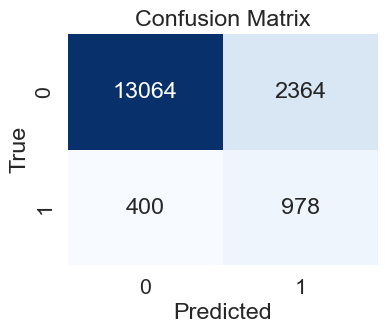

In [241]:
confusion = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 3))
sns.set(font_scale=1.4)  # Adjust the font scale for readability
# Use seaborn's heatmap to plot the confusion matrix
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=[0, 1], yticklabels=[0, 1])
# Set axis labels
plt.xlabel('Predicted')
plt.ylabel('True')
# Add a title
plt.title('Confusion Matrix')
# Show the plot
plt.show()

0.8666793839485856


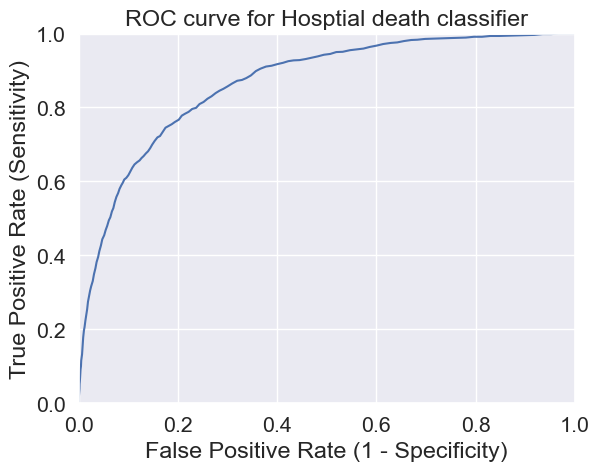

In [242]:
y_pred_prob = best_model.predict_proba(X_ktest)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for Hosptial death classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)
print(roc_auc_score(y_test, y_pred_prob))

After tuning the hyperparameters, we find our best model: Random Forest. Its train accuracy is 0.9534 and test accuracy is 0.9095, which is much higher than the result before the tuning. Its overall f1 score is around 0.47 and its AUC score is around 0.87. These three metrics for Random Forest all ranks the top.

# 11. Evaluate & Save The Best Model<a id='11'></a>

## 11.1 Evaluate the Feature Importance<a id='11.1'></a>

In [76]:
best_model = rf_random_search.best_estimator_
importances = best_model.named_steps['model'].feature_importances_
feature_importance=pd.DataFrame({'Feature_Names': select_name, 'Feature_Importance(%)': importances*100}).sort_values(by='Feature_Importance(%)', ascending=False)

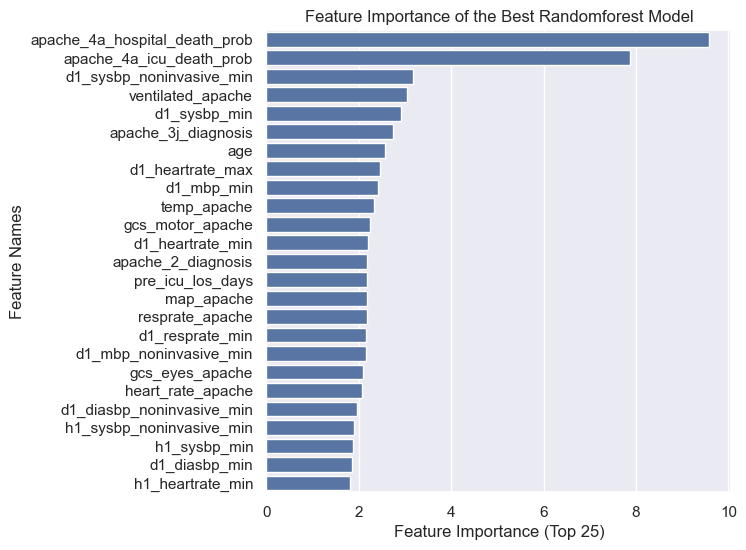

In [244]:
plt.figure(figsize=(6, 6))
sns.set(font_scale=1)
ax=sns.barplot(feature_importance.head(25),
               x='Feature_Importance(%)',
               y='Feature_Names')
plt.xlabel('Feature Importance (Top 25)')
plt.ylabel('Feature Names')
# Add a title
plt.title('Feature Importance of the Best Randomforest Model')
# Show the plot
plt.show()

Our best model has 60 features in total. Apache_4a_hospital_death_prob and apache_4a_icu_death_prob out of all the 60 features contribute the most. But together they explain around 18% of the model. The rest 58 features together explain the rest 82%.\
Definition of these two most important features:\
Apache_4a_hospital_death_prob : The APACHE IVa probabilistic prediction of in-hospital mortality for the patient which utilizes the APACHE III score and other covariates, including diagnosis.\
Apache_4a_icu_death_prob: The APACHE IVa probabilistic prediction of in ICU mortality for the patient which utilizes the APACHE III score and other covariates, including diagnosis. 

In [77]:
top15feature_list=feature_importance.head(15).Feature_Names.tolist()
top15feature=pd.concat([X_train.loc[:,top15feature_list], y_train], axis=1)

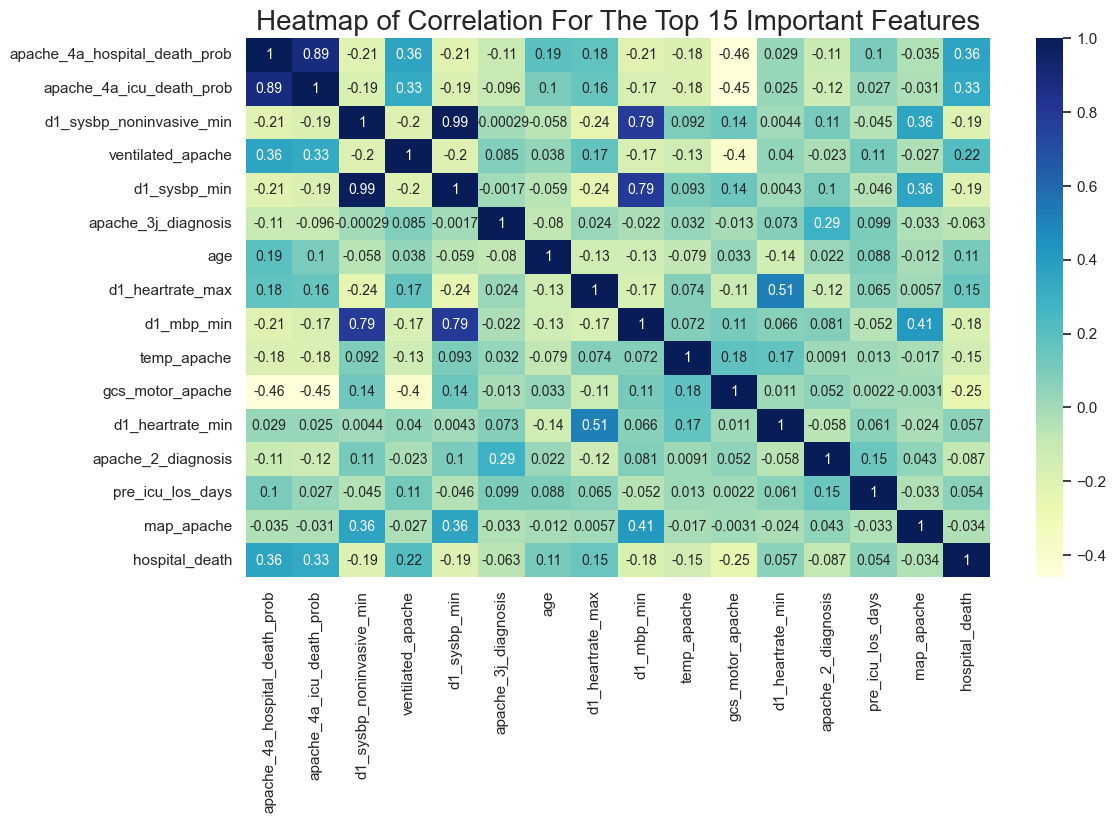

In [279]:
# plotting correlation heatmap 
_ = plt.figure(figsize=(12,7))
_ =sns.heatmap(top15feature.corr(method='pearson'), cmap="YlGnBu", annot=True, annot_kws={'size':10}) 
_ = plt.title('Heatmap of Correlation For The Top 15 Important Features', size=20)

From above heatmap we can see that for the top 15 important features, there are 7 features that have positive correlation with our target feature: hospital death, these features are: 'apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob', 'ventilated_apache', 'age', 'd1_heartrate_max', 'd1_heartrate_min','pre_icu_los_days', 'hospital_death'.\
The rest features are negatively correlate with our target feature, they are: 'd1_sysbp_noninvasive_min', 'd1_sysbp_min','apache_3j_diagnosis', 'd1_mbp_min', 'temp_apache', 'gcs_motor_apache', 'apache_2_diagnosis', 'map_apache'

In [81]:
def deathrate(col_name,data=top15feature):
    death_by_col= data[data.hospital_death==1][col_name].value_counts()
    deathrate_by_col = death_by_col/data[col_name].value_counts()
    return deathrate_by_col

Death Rate by 'ventilated_apache'

In [82]:
deathrate('ventilated_apache')

ventilated_apache
0.0    0.039836
1.0    0.167395
Name: count, dtype: float64

Death Rate by 'gcs_motor_apache'

In [91]:
deathrate('gcs_motor_apache')

gcs_motor_apache
0.693147    0.317521
1.098612    0.278539
1.386294    0.241192
1.609438    0.173588
1.791759    0.122168
1.945910    0.051418
Name: count, dtype: float64

The average d1_heartrate_max is much higher if the patient not survive in the end.

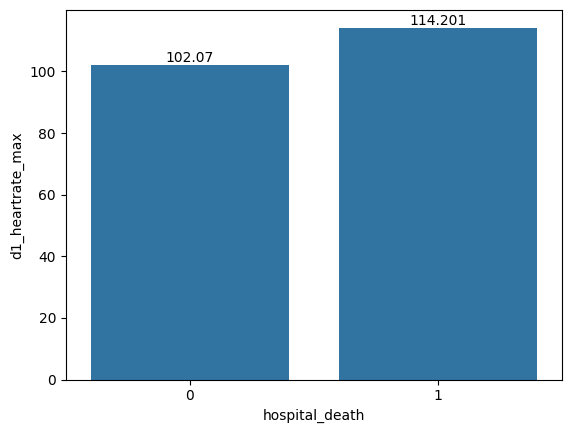

In [90]:
ax=sns.barplot(data=top15feature,
                x='hospital_death',
                y='d1_heartrate_max',
                estimator='mean', 
                errorbar=None,)
ax.bar_label(ax.containers[0], fontsize=10);

The average d1_sysbp_noninvasive_min is much lower if the patient did not survive in the end.

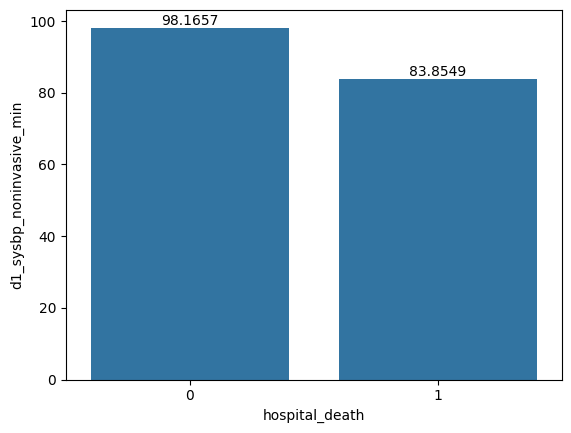

In [92]:
ax=sns.barplot(data=top15feature,
                x='hospital_death',
                y='d1_sysbp_noninvasive_min',
                estimator='mean', 
                errorbar=None,)
ax.bar_label(ax.containers[0], fontsize=10);

## 11.2 Evaluate the Predictive power<a id='11.2'></a>

In [229]:
X_test.head()

,age,bmi,height,pre_icu_los_days,weight,apache_2_diagnosis,apache_3j_diagnosis,arf_apache,gcs_eyes_apache,gcs_motor_apache,...,apache_3j_bodysystem_Gastrointestinal,apache_3j_bodysystem_Genitourinary,apache_3j_bodysystem_Gynecological,apache_3j_bodysystem_Hematological,apache_3j_bodysystem_Metabolic,apache_3j_bodysystem_Musculoskeletal/Skin,apache_3j_bodysystem_Neurological,apache_3j_bodysystem_Respiratory,apache_3j_bodysystem_Sepsis,apache_3j_bodysystem_Trauma
62903,62.280384,1.459471,149.90,0.620584,1.627804,113.0,1.976675,0.0,4.0,5.0,...,0,0,0,0,0,0,0,0,1,0
15088,48.000000,1.437438,187.96,0.322534,1.694266,105.0,1.846498,0.0,4.0,6.0,...,0,0,0,0,0,0,0,1,0,0
82298,89.000000,1.481454,157.50,0.008265,1.665386,109.0,1.738963,0.0,4.0,6.0,...,0,0,0,0,0,0,0,0,0,0
75665,83.000000,1.490088,172.70,0.164534,1.706321,110.0,1.732373,0.0,3.0,5.0,...,0,0,0,0,0,0,0,0,0,0
54757,71.000000,1.498426,149.90,0.429397,1.661441,302.0,1.734065,0.0,4.0,6.0,...,0,0,0,0,0,0,0,0,0,0


### 11.2.1 Use apache_4a_icu_death_prob to predict the patient death<a id='11.2.1'></a>

The APACHE IVa probabilistic prediction of in ICU mortality for the patient which utilizes the APACHE III score and other covariates, including diagnosis. The hospital was using this score to predict the patient death. We will investigate the predictive power of this methord and compare it with our best model's predictive power.

In [232]:
from sklearn.preprocessing import binarize
# it will return 1 for all values above 0.5 and 0 otherwise
apache_4a_icu_death_prob=X_test.apache_4a_icu_death_prob.values
apache_4a_icu_death_pred_class = binarize(apache_4a_icu_death_prob.reshape(-1, 1), threshold=0.5)
confusion = confusion_matrix(y_test, apache_4a_icu_death_pred_class)
accuracy = accuracy_score(y_test, apache_4a_icu_death_pred_class)
report = classification_report(y_test, apache_4a_icu_death_pred_class)
print("Apache_4a_icu_death Prediction Accuracy:", accuracy)
print('AUC Score: ',roc_auc_score(y_test, apache_4a_icu_death_prob))
print("Classification Report:\n", report)
print(confusion)

Apache_4a_icu_death Prediction Accuracy: 0.9022372962037367
AUC Score:  0.8270127532810306
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.98      0.95     15428
           1       0.10      0.02      0.04      1378

    accuracy                           0.90     16806
   macro avg       0.51      0.50      0.49     16806
weighted avg       0.85      0.90      0.87     16806

[[15131   297]
 [ 1346    32]]


### 11.2.2 Use apache_4a_hospital_death_prob to predict the patient death<a id='11.2.2'></a>

The APACHE IVa probabilistic prediction of in-hospital mortality for the patient which utilizes the APACHE III score and other covariates, including diagnosis. The hospital was using this score to predict the patient death besides the apache_4a_icu_death_prob score. We will investigate the predictive power of this methord and compare it with our best model's predictive power as well.

In [234]:
apache_4a_hospital_death_prob=X_test.apache_4a_hospital_death_prob.values
apache_4a_hospital_death_pred_class = binarize(apache_4a_hospital_death_prob.reshape(-1, 1), threshold=0.5)
confusion = confusion_matrix(y_test, apache_4a_hospital_death_pred_class)
accuracy = accuracy_score(y_test, apache_4a_hospital_death_pred_class)
report = classification_report(y_test, apache_4a_hospital_death_pred_class)
print("Apache_4a_hospital_death Prediction Accuracy:", accuracy)
print('AUC Score: ',roc_auc_score(y_test, apache_4a_hospital_death_prob))
print("Classification Report:\n", report)
print(confusion)

Apache_4a_hospital_death Prediction Accuracy: 0.903070332024277
AUC Score:  0.8346481554092929
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.98      0.95     15428
           1       0.15      0.04      0.06      1378

    accuracy                           0.90     16806
   macro avg       0.54      0.51      0.51     16806
weighted avg       0.86      0.90      0.88     16806

[[15121   307]
 [ 1322    56]]


### 11.2.3 The predictive power of our best model<a id='11.2.3'></a>

In [238]:
y_pred = best_model.predict(X_ktest)
y_pred_prob = best_model.predict_proba(X_ktest)[:, 1]
y_trainpred = best_model.predict(X_ktrain)
accuracy_test = accuracy_score(y_test, y_pred)
accuracy_train= accuracy_score(y_train, y_trainpred)
report = classification_report(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
print("Train Accuracy:",accuracy_train)
print("Test Accuracy:", accuracy_test)
print('AUC Score: ',roc_auc_score(y_test, y_pred_prob))
print("Classification Report:\n", report)
print(confusion)

Train Accuracy: 0.953436477238917
Test Accuracy: 0.9094966083541592
AUC Score:  0.8682881726361849
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95     15428
           1       0.45      0.47      0.46      1378

    accuracy                           0.91     16806
   macro avg       0.70      0.71      0.71     16806
weighted avg       0.91      0.91      0.91     16806

[[14631   797]
 [  724   654]]


From the result, when use the apache_4a_icu_death_prob or the apache_4a_hospital_death_prob to predict the patient death, both have a relatively high accuracy. But when you look at the confusion matrix, you will notice that both methods perform pool on predicting the positive value which means use these methods you can predict the patient that will survive with a high prediction accuracy, but you can hardly target the patient that will die.  Our model in the other hand, somehow it increases the false negative rate for the patient survived, but it also hugely increases the precision and recall for the patient death prediction.

## 11.3 Save the Best Model<a id='11.3'></a>

In [246]:
import datetime
best_model = rf_random_search.best_estimator_
best_model.version = '1.0'
best_model.pandas_version = pd.__version__
best_model.numpy_version = np.__version__
best_model.sklearn_version = sklearn_version
best_model.X_columns = [col for col in select_name]
best_model.build_datetime = datetime.datetime.now()

In [247]:
import pickle
pickle.dump(best_model, open('Patient_Survival_Prediction_model.pkl', 'wb'))